In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [ ]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the Random Forest Classifier from scratch with enhancements
class RandomForestClassifierEnhanced:
    def __init__(self, n_estimators=100, max_depth=None, max_features="sqrt"):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X.iloc[indices]
            y_sample = y[indices]

            # Random feature subset
            max_features = (
                int(np.sqrt(n_features)) if self.max_features == "sqrt" else n_features
            )
            feature_subset = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_subset)

            # Train decision tree
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_sample.iloc[:, feature_subset], y_sample)

            # Save the trained tree
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, (tree, feature_subset) in enumerate(zip(self.trees, self.feature_indices)):
            predictions[:, i] = tree.predict(X.iloc[:, feature_subset])
        # Majority vote
        return np.array([np.bincount(row.astype(int)).argmax() for row in predictions])

    def feature_importances(self, X):
        # Compute feature importances based on splits across all trees
        importances = np.zeros(X.shape[1])
        for tree, feature_subset in zip(self.trees, self.feature_indices):
            tree_importances = tree.feature_importances_
            importances[feature_subset] += tree_importances
        return importances / self.n_estimators


In [ ]:
# Train the Random Forest model
rf = RandomForestClassifierEnhanced(n_estimators=100, max_depth=10, max_features="sqrt")
rf.fit(X_train, y_train)

In [ ]:
# Make predictions and evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Random Forest): {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy (Random Forest): 0.9649

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# Feature importance analysis
importances = rf.feature_importances(X_train)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

<ipython-input-9-611d3527d54f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


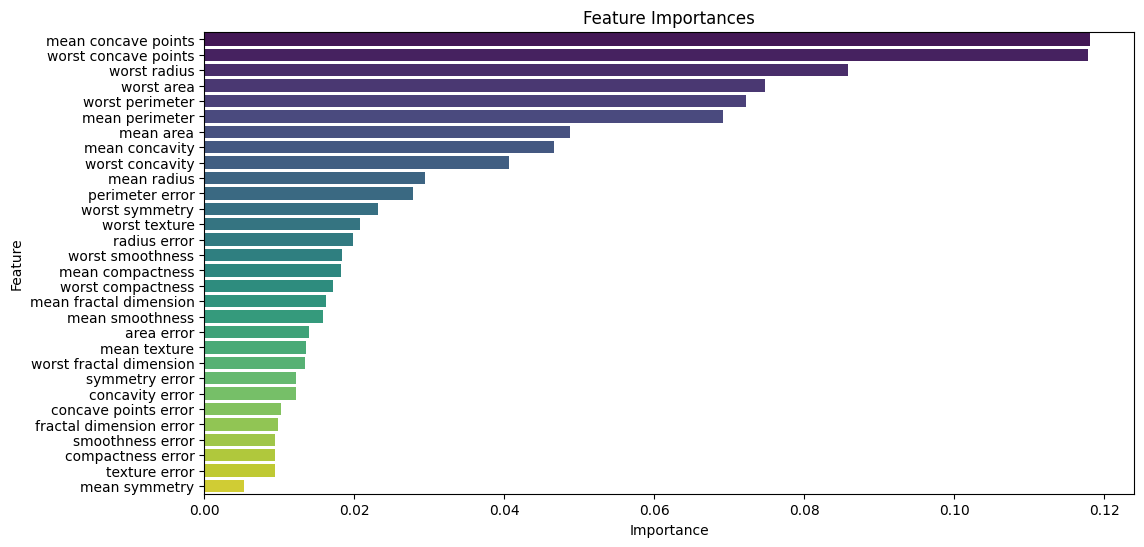

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances")
plt.show()

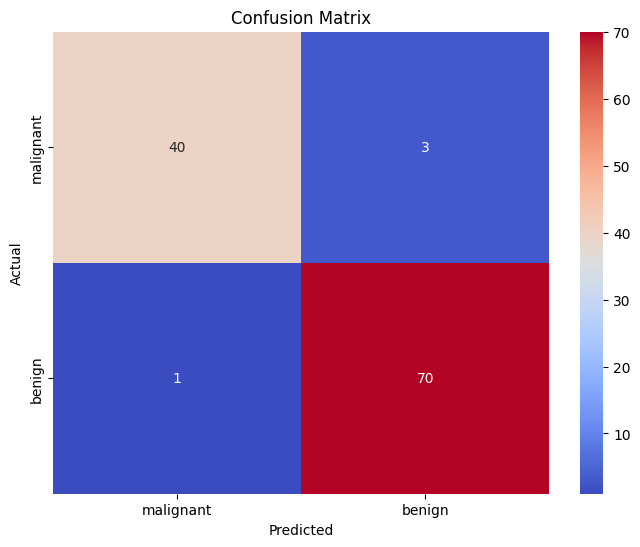

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest Method
Random Forest is an ensemble learning algorithm that combines multiple decision trees to produce a more robust and accurate model. It is commonly used for both classification and regression tasks.

Key Concepts in Random Forest
Ensemble Learning:

Random Forest is an example of ensemble learning where multiple models (decision trees) are combined to improve overall performance.
Bagging (Bootstrap Aggregating):

Each tree is trained on a random subset of the dataset (with replacement, called bootstrapping).
This reduces overfitting and improves generalization.
Feature Randomization:

At each split in a decision tree, a random subset of features is considered for splitting.
This introduces diversity among the trees and reduces correlation between them.
Aggregation of Predictions:

For classification, the predictions are combined using majority voting (the most common class is selected).
For regression, predictions are averaged to produce the final result.
Steps in Random Forest
Dataset Sampling:

Create multiple bootstrap samples from the original dataset.
Build Decision Trees:

Train a decision tree on each bootstrap sample.
Use a random subset of features at each split to decorrelate the trees.
Aggregate Predictions:

For classification: Majority voting.
For regression: Averaging.
Advantages of Random Forest
High Accuracy:

Combines multiple models to reduce variance and bias.
Resistant to Overfitting:

Bagging and feature randomization prevent overfitting even with deep trees.
Handles High-Dimensional Data:

Works well with datasets with a large number of features and instances.
Feature Importance:

Provides insights into the importance of features in making predictions.
Disadvantages of Random Forest
Computationally Expensive:

Training and predicting with a large number of trees can be slow.
Less Interpretability:

Unlike a single decision tree, Random Forest is a "black-box" model, making it harder to interpret.
Applications
Classification: Disease prediction, fraud detection, image recognition.
Regression: Stock price prediction, real estate price prediction.
Comparison with Decision Trees
Random Forest reduces the high variance of individual decision trees by averaging their predictions, resulting in better generalization.
